# Overview


1. [Introduction](#Getting-Started)
2. [Setup & Data analysis](#)
    * [Install additional libraries](#)
    * [Import installed libraries](#)
    * [Download and read data](#)
    * [Preprocessing and data analysis](#)  
3. [Measure fairness on test set (before applying a ML model)](#)
    * [Metrics used to measure fairness](#)
    * [Measure of fairness on test set](#)
4. [Apply a simple machine learning model : Logistic Regression](#)
    * [Simple explanations about logistic regression](#)
    * [Apply a logistic regression model](#)
    * [Evaluate results](#)

5. [Apply a logistic regression model](#)    
6. [Impacts of swapping gender attributes on loan eligibility](#)
7. [Correcting Bias](#)
8. [Conclusion](#)


# 1. Introduction
This notebook aims to show that machine learning models are exposed to risks like risks of bias, and to introduce some simple techniques to detect and mitigate bias.

In this case study, we suppose that we are working for a credit institution. The client wants to automate the loan eligibility process thanks to a binary classification ML model trained on historical data.

Regarding the dataset used in this notebook, it comes from a public challenge organized by the company Analytics Vidhya. It contains details about customers details such as Gender, Marital Status, Education, Number of Dependents, Income, Loan Amount, Credit History and others as well as the related loan status.

Given these customer information, the purpose of the binary classification model is to predict the loan status : yes or no. In this notebook, we are going to apply a logistic regression model as a binary classifier.

# 2. Setup & Data analysis

## 2.1 Install additional libraries

In [1]:
# If you use Google Colab, run this cell
!pip install aif360
!pip install BlackBoxAuditing 
!pip install fairlearn

## 2.2 Import installed libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import math
from sklearn import metrics
from aif360.metrics import classification_metric
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import DisparateImpactRemover, Reweighing
from aif360.datasets import BinaryLabelDataset
from IPython.display import Markdown, display
# To display plots
%matplotlib inline

warnings.filterwarnings('ignore')
sns.set(rc={'figure.figsize':(20, 7)})

## 2.3 Download & read data




In [ ]:
loan_data = pd.read_csv("loan_applicants_case")
loan_data

,Unnamed: 0,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,0,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
1,1,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
2,2,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
3,3,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
4,4,LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
764,764,LP002969,Male,Yes,1,Graduate,No,2269,2167.0,99.0,360.0,1.0,Semiurban,Y
765,765,LP002971,Male,Yes,3+,Not Graduate,Yes,4009,1777.0,113.0,360.0,1.0,Urban,Y
766,766,LP002975,Male,Yes,0,Graduate,No,4158,709.0,115.0,360.0,1.0,Urban,Y
767,767,LP002986,Male,Yes,0,Graduate,No,5000,2393.0,158.0,360.0,1.0,Rural,N


## 2.4 Getting started

**Get dataset info**

In [ ]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 769 entries, 0 to 768
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         769 non-null    int64  
 1   Loan_ID            769 non-null    object 
 2   Gender             769 non-null    object 
 3   Married            769 non-null    object 
 4   Dependents         769 non-null    object 
 5   Education          769 non-null    object 
 6   Self_Employed      769 non-null    object 
 7   ApplicantIncome    769 non-null    int64  
 8   CoapplicantIncome  769 non-null    float64
 9   LoanAmount         769 non-null    float64
 10  Loan_Amount_Term   769 non-null    float64
 11  Credit_History     769 non-null    float64
 12  Property_Area      769 non-null    object 
 13  Loan_Status        769 non-null    object 
dtypes: float64(4), int64(2), object(8)
memory usage: 84.2+ KB


In [ ]:
loan_data.isnull().sum()

Unnamed: 0           0
Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

As you may have noticed, there are no null values in the dataframe. The reason is because this is a quite clean dataset that has already been processed. 
In real life scenarios, datasets often contain special characters, missing values, etc. which induce a lot of processing before modeling

There are two columns that won't be needed in our study. Let's delete them

In [ ]:
del loan_data['Loan_ID']
del loan_data['Unnamed: 0']

In [ ]:
loan_data.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
1,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
2,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
3,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
4,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y


----
*Given the dataset and the goal we assign ourself (predict loan eligibility) for this study, do you think there's a risk of biais ?*


---

---
*What might be a potential source of bias ?*

---

---
*What would you suggest to do first before starting modeling in order to verify that a model might be or not be subjected to bias if trained with the dataset?*

---

## 2.5  Exploratory analysis

Assessing fairness does not start when you have your final model. It should also be a part of your exploratory analysis. 

In general, we do this to build some intuition around our dataset. So, when it comes to modelling, you have a good idea of what results to expect. Specifically, for fairness, you want to understand what aspects of your data may lead to an unfair model.

---

A model can become unfair due to different sources of bias. There are 2 classes of bias : bias related to data and bias related to model building. In our exploratory analysis, we will focus on 1st class. We want to understand the extent to which these are present in our data.

---

**Next steps**

---

Plot the breakdown of our dataset population by Loan Status and *Gender*

---

Plot the loan status distribution by Gender

---

#### Plots

**Unbalanced dataset**

We will start by seeing if our dataset is unbalanced. Specifically, we mean unbalanced in terms of the sensitive attributes and the target attribute.

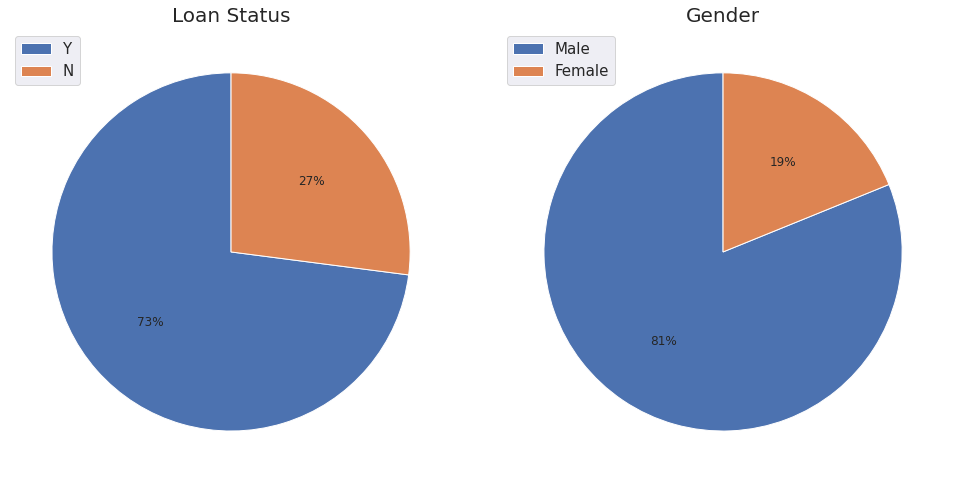

In [ ]:
plt.figure(figsize=(14, 7))
plt.subplot(121)

#Plot breakdown by Loan status
counts = loan_data['Loan_Status'].value_counts()
labels = counts.index

plt.pie(counts, autopct='%.0f%%', startangle=90)
plt.legend(labels, loc=2,fontsize=15)
plt.title("Loan Status",size=20)

plt.subplot(122)

#Plot breakdown by Gender
counts = loan_data['Gender'].value_counts()
labels = counts.index

plt.pie(counts,autopct='%.0f%%', startangle=90)
plt.legend(labels, loc=2,fontsize=15)

plt.title("Gender",size=20)



plt.tight_layout(pad=2)

Looking at Figure above, we have the breakdown of the population by Gender and Loan approval. Cleary, there is a significant imbalance between classes. Our model could easily end up highly biased towards the majority class. In fact, if the model simply always predicts loan approval, it would already have around **72%** accuracy with this data.

---

We also have imbalance in sensitive attribute. The second chart shows that **81%** of our population is male. 

Men are overrepresented in the dataset. There are 4x more men than women in which may imply that more men have their loans accepted.

In [ ]:
male_accepted_loans = loan_data[(loan_data.Gender=="Male") \
                                & (loan_data.Loan_Status=="Y")]
female_accepted_loans = loan_data[(loan_data.Gender=="Female") \
                                  & (loan_data.Loan_Status=="Y")]

print('There are {} men with accepted loans'.format(len(male_accepted_loans)))
print('Only {} women have their loans accepted'.format(len(female_accepted_loans)))

There are 462 men with accepted loans
Only 99 women have their loans accepted


Loan acceptance for men is 4x greater than the female population.

**Prevalence**

For a target variable, prevalence is the proportion of the positive cases to overall cases where a positive case is when the target variable has a value of 1. Prevalence can also be used to help us understand in depth our data.

We do this by calculating prevalence for our different privileged (1) and unprivileged (0) groups and the prevalence at the intersection of the protected features

In [ ]:
def compute_prevalence(input_df):
  """
  This function compute prevalence that can be used to assess the breakdown
  of the dataset given protected attributes
  """
  df = input_df[['Gender','Married', 'Loan_Status']].copy()

  #Define protected features 
  df['Married'] = [1 if r=='Yes' else 0 for r in df['Married']]
  df['Gender'] = [1 if s=='Male' else 0 for s in df['Gender']]

  #Define target variable 
  df['y'] =  [1 if y == 'Y'else 0 for y in df['Loan_Status']]

  prev = df['y'].mean()
  prev_married = df.groupby('Married')['y'].mean()
  prev_gender = df.groupby('Gender')['y'].mean()
  prev_comb = df.groupby(['Married','Gender'])['y'].mean()

  print(f"Overall dataset prevalence : {prev}")
  print('------------------------------------')
  print(f"Marriage status prevalence : \n {pd.DataFrame(prev_married)}")
  print('------------------------------------')
  print(f"Gender prevalence : \n {pd.DataFrame(prev_gender)}")
  print('------------------------------------')
  print(f"Prevalence at the intersection Married vs Gender : \n {pd.DataFrame(prev_comb)}")

In [ ]:
compute_prevalence(loan_data)

Overall dataset prevalence : 0.729518855656697
------------------------------------
Marriage status prevalence : 
                 y
Married          
0        0.660517
1        0.767068
------------------------------------
Gender prevalence : 
                y
Gender          
0       0.682759
1       0.740385
------------------------------------
Prevalence at the intersection Married vs Gender : 
                        y
Married Gender          
0       0       0.649485
        1       0.666667
1       0       0.750000
        1       0.768889


Prevalence is higher for priviledge groups though there's not a significant difference between our categories (2x or more prevalence) 

----
**We actually cannot conclude from these observations that women will be discriminated against because of their gender. Maybe the eligibility to a loan depends for instance on the applicant income. If so, if men earn 4x more then women, this might explain the differences in prevalences and loan eligibility approval.**

----

Let's compare male and female population income and see to what extend the income impact our target variable.

**Comparing income**

In below cell, we make bins for the applicant income variable based on the values in it and analyze the corresponding loan status for each bin. 

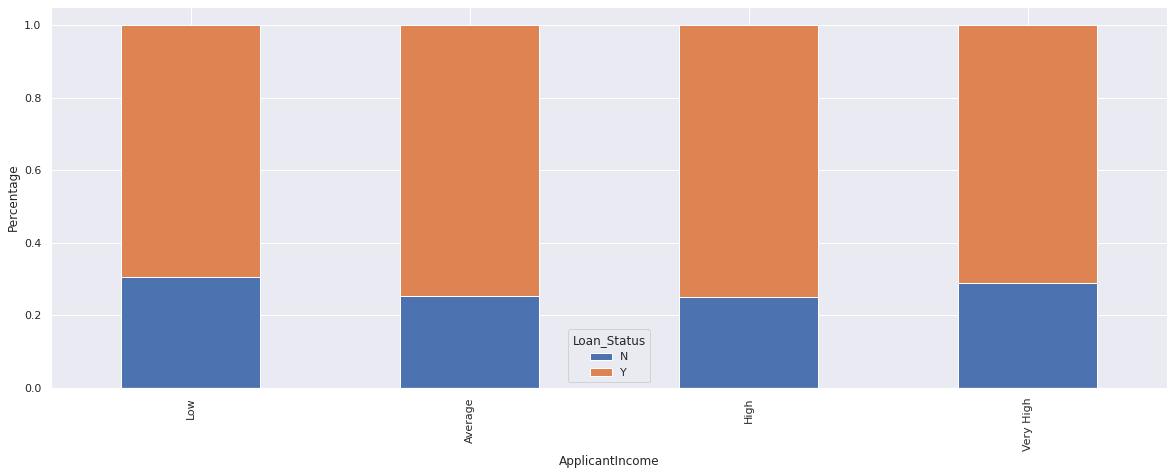

In [ ]:
bins=[0, 2500, 4000, 6000, 81000]
group=['Low','Average', 'High','Very High']
df_bins = loan_data.copy()
df_bins['Income_bin']= pd.cut(df_bins['ApplicantIncome'], bins,labels=group)
Income_bin = pd.crosstab(df_bins['Income_bin'], df_bins['Loan_Status'])
Income_bin.div(Income_bin.sum(1).astype(float), axis=0).plot(kind='bar',stacked=True)
plt.xlabel('ApplicantIncome')
P=plt.ylabel('Percentage')

It can be inferred that Applicant's income does not affect the chances of loan approval which sounds actually surprising we often assume that if the applicant's income is high the chances of loan approval will also be high.

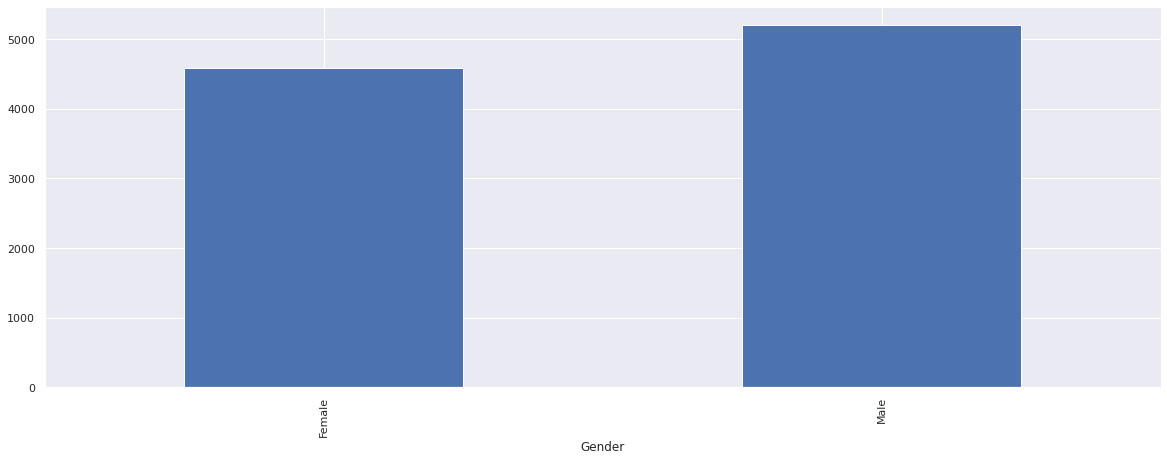

In [ ]:
loan_data.groupby('Gender')['ApplicantIncome'].mean().plot.bar()

**On average, men earn a bit more than women but the differences between their  incomes are not as high as we expected**

<b/>

Now let’s look at the correlation between all the numerical variables. We will use the heat map to visualize the correlation. Heatmaps visualize data through variations in coloring. The variables with darker color means their correlation is more.

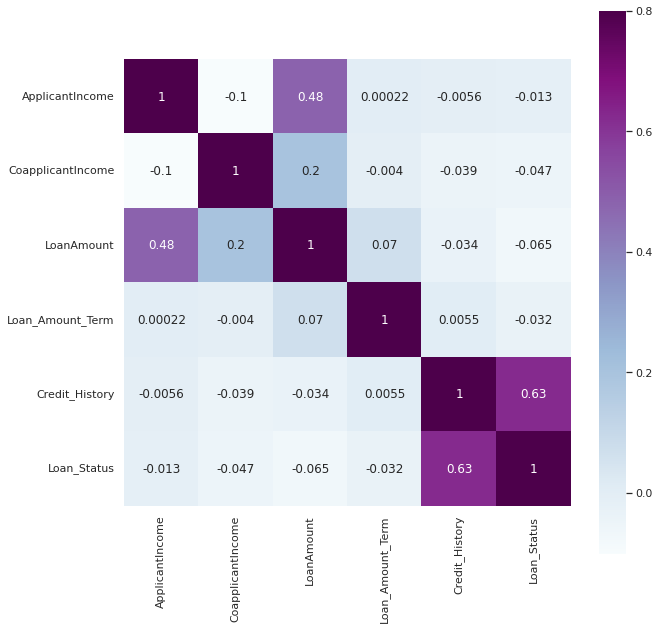

In [ ]:
df_corr = loan_data.copy()
df_corr['Loan_Status'].replace('N', 0,inplace=True)
df_corr['Loan_Status'].replace('Y', 1,inplace=True)
matrix = df_corr.corr()
f, ax = plt.subplots(figsize=(10,10))
sns.heatmap(matrix, vmax=.8,square=True,cmap='BuPu', annot = True)

---
**We see that the most correlated variables are Credit_History — Loan_Status.**

Even though men earn a bit more than women, since **income** is not much correlated to the Loan Status (target), this variable cannot explain potential difference in loan eligibility between male and female population once we train a machine learning model.

---

Let us now compare men and women credit history (the attribute that is the most correlated to loan status)

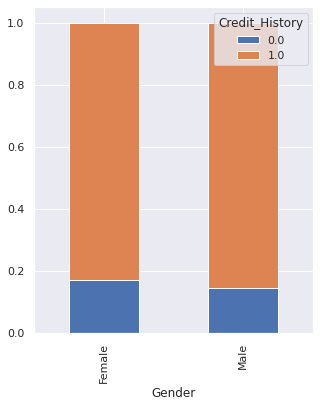

In [ ]:
credit_history = pd.crosstab(loan_data['Gender'],loan_data['Credit_History'])
credit_history.div(credit_history.sum(1).astype(float), axis=0).plot(kind='bar',stacked=True,figsize=(5,6))
plt.show()

As seen previously, people with a credit history as 1 are more likely to get their loans approved which led us to believe that if more men have their loans approved, it is probably due to :

1. High income (this is not the case)
2. Other attributes (e.g. credit history) that might be in favor of men and that are correlated with our target (Loan Status)


The above plot invalidate the second hypothesis. The credit history for both male and female population are almost the same. 

#### **Data encoding : Converting categorical data to numeric**

We will use pandas get_dummies function to convert categorical variables to numeric ones since we can't feed most of machine learning models with text data.

The categorical variables are : 'Married', 'Education', 'Dependents', 'Self_Emplyed', 'Property_Area'.

They are converted using label encoding technique which simply replaces the categorical values of a variable with a numeric value between 0 and the number of categories minus 1.



In [ ]:
def categorical_numeric(col_list, dataframe):
    '''
    Input:
        col_list: list of categorical variables
        dataframe : original dataframe
    Output:
        df: dataframe with transformed categorical variables
    '''
    df_cat_to_numeric = pd.get_dummies(dataframe[col_list])
    return df_cat_to_numeric

In [ ]:
cat_columns = ['Married',  'Education', 'Dependents', 'Self_Employed', 'Property_Area']
df_cat_variables = categorical_numeric(cat_columns, loan_data)
df_cat_variables.head()

,Married_No,Married_Yes,Education_Graduate,Education_Not Graduate,Dependents_0,Dependents_1,Dependents_2,Dependents_3+,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,0,1,1,0,0,1,0,0,1,0,1,0,0
1,0,1,1,0,1,0,0,0,0,1,0,0,1
2,0,1,0,1,1,0,0,0,1,0,0,0,1
3,1,0,1,0,1,0,0,0,1,0,0,0,1
4,0,1,1,0,0,0,1,0,0,1,0,0,1


Our target is the loan_status. We also have to convert the column as well as the gender column to numeric columns. A 'Male' Gender and a 'Yes' Loan_Status will be encoded with 1. A 'Female' Gender and a 'No' Loan_Status by 0.

In [ ]:
loan_data.loc[loan_data.Gender == 'Male', 'Gender'] = 1
loan_data.loc[loan_data.Gender == 'Female', 'Gender'] = 0

loan_data.loc[loan_data.Loan_Status == 'Y', 'Loan_Status'] = 1
loan_data.loc[loan_data.Loan_Status == 'N', 'Loan_Status'] = 0


In [ ]:
loan_data = loan_data.drop(columns=cat_columns)
loan_data.head(3)

,Gender,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status
0,1,4583,1508.0,128.0,360.0,1.0,0
1,1,3000,0.0,66.0,360.0,1.0,1
2,1,2583,2358.0,120.0,360.0,1.0,1


Now we can merge the above dataframe with the one we created with the categorical columns

In [ ]:
def concatenate_dataframe(df1, df2):
    """ 
    Input:
        df1 and df2 : the two dataframes to be concatenated
    Ouput:
    dataframe which is the concatanation of the inputs
    """
    df_concat = pd.concat([df1,df2], axis=1)
    return df_concat

In [ ]:
df_final = concatenate_dataframe(loan_data, df_cat_variables)
df_final.head()

,Gender,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Married_No,Married_Yes,Education_Graduate,Education_Not Graduate,Dependents_0,Dependents_1,Dependents_2,Dependents_3+,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,1,4583,1508.0,128.0,360.0,1.0,0,0,1,1,0,0,1,0,0,1,0,1,0,0
1,1,3000,0.0,66.0,360.0,1.0,1,0,1,1,0,1,0,0,0,0,1,0,0,1
2,1,2583,2358.0,120.0,360.0,1.0,1,0,1,0,1,1,0,0,0,1,0,0,0,1
3,1,6000,0.0,141.0,360.0,1.0,1,1,0,1,0,1,0,0,0,1,0,0,0,1
4,1,5417,4196.0,267.0,360.0,1.0,1,0,1,1,0,0,0,1,0,0,1,0,0,1


**Split the dataframe into train and test test**

We are now ready to split our dataframe into train and test set for our classification model (Logistic Regresion). 80% of the data will be used to train the logistic and regression model and the remaining 20% will be used as test set.

In [ ]:
#Define the input variables 
X = df_final.drop('Loan_Status', axis=1)  
#Define our target variable
y =  df_final['Loan_Status']   
#Split into train and test set                 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# **3. Quantify bias**

## **3.1 Your turn**

---

How would you identify and quantify bias in dataset ?

---



# **3.2 Measure fairness (before applying a ML model)**

## 3.2.1 Metrics used to measure fairness

There are various metrics to measure the fairness of a dataset or of the output of a machine learning model.
Two classical and intuitive ones are called "Desperate Impact (DI)" and "Statistical Parity Difference (SDP)".

**Metrics :** 

* **Disparate  Impact (DI)** : 


The ratio of rate of favorable outcome (acceptance of loan) for the unprivileged group (women in our case) to that of the privileged group (men). 

This metric has to be equal to 1 to be perfectly fair. The disproportionate effect is considered as important when DI is less than 80-85%. 

Industry standard: if the unprivileged group receives a positive outcome less than 85% of their proportion of the privileged group, this is a disparate impact violation

$$ DI = \frac{Pr(Loan\_Status=1|Gender=Female)}{Pr(Loan\_Status=1|Gender=Male)}$$

Disparate impact refers to discrimination that is unintentional. This is a more subtle form of discrimination since it is usually unintentional. It occurs when two groups are treated equally within a given set of organizational rules and procedures, but the rules and procedures confer advantages to one group over another, and at the same time are irrelevant for job or organizational performance.



Let's illustrate with an example.



---


> Let **X** be a company that receives 300 applications for a Machine Learning internship position. Half of the applications are from male candidates and the other half female candidates. The company selects **75 women** and **120 men** from all applications. The question one may asks is : does this selection adversely impact female applicants ? 

> Selection rates for men and women are respectively $\frac{120}{150}$ and $\frac{75}{150}$ ( $80\%$ for men and $50\%$ for women). In our example, men have the highest selection rate. They're therefore what we called the *priviledged group*.
<br/>

> Let's now divide female selection rate by the male one which will give us the Desparate Impact. We find that $DI=62.5\% \lt 80\%$ which means that there's an adverse impact on the female group.
---





* **Statistical Parity Difference (SPD)**:
  
  When SPD is close to 0, it is fair. 

$$SPD = Pr(Loan\_Status=1|Gender=Female)−Pr(Loan\_Status=1|Gender=Male)$$


> In the previous example, $SPD = \frac{120}{150} - \frac{75}{150} = 0.3 $ 

## 3.2.2 Measure of fairness on test set

In this section, we compute DI and SPD in order to check for the bias in the dataset.

In [ ]:
# copy of the test dataset
test_fairness = X_test.copy()
test_fairness['Target'] = y_test

# Calculation of DI and SPD
df_male = test_fairness[test_fairness['Gender'] == 1]
male_count = len(df_male)
df_female = test_fairness[test_fairness['Gender'] == 0]
female_count = len(df_female)


female_accepted_loans_count = len(df_female[df_female['Target'] == 1])
female_ratio = female_accepted_loans_count/female_count


male_accepted_loans_count = len(df_male[df_male['Target'] == 1])
male_ratio = male_accepted_loans_count/male_count

desperate_impact = female_ratio/male_ratio

spd = female_ratio - male_ratio

In [ ]:
print("Female favorable outcome rate:\t%.2f" % female_ratio)
print('------------------------------------')
print("Male favorable outcome rate:\t%.2f" % male_ratio)
print('------------------------------------')
print("Desparate Impact value:\t\t%.2f" % desperate_impact)
print('------------------------------------')
print("Statistical Parity Difference: %.2f" % spd)


Female favorable outcome rate:	0.60
------------------------------------
Male favorable outcome rate:	0.72
------------------------------------
Desparate Impact value:		0.83
------------------------------------
Statistical Parity Difference: -0.12


Since disparate impact is equal to 0.83, it may not be considered that there is a significant "adverse impact". However, the metrics can lead us into  believing that this small adversial impact can be worsen by a ML model.

# 4. Apply a simple machine learning model : Logistic Regression
The purpose of the ML model is to make a binary classification - predict either a loan will be accepted or rejected - given the explicative variables. 

## 4.1 Simple explanations about logistic regression

Logistic Regression is a classification algorithm that assigns observations to a set of classes. Here, we have two classes: accepted and rejected loan.<br>

As its name suggests, logistic regression is based on the regression of a logistic function (or sigmoid function). This function has the particularity to map every real value into another value between 0 and 1. After having computed the regression coefficients of a such function thanks to train data, the output of this function can be seen as a probability of belonging to class "Accepted".<br>

<img src="https://miro.medium.com/max/1094/1*JHWL_71qml0kP_Imyx4zBg.png" align="center" alt="sigmoid function" width="350"/><br>

To assign each predicted probability from the logistic function to a class, we define a threshold of 0.5. If a predicted probability >= 0.5, then an observation is assigned to class "Accepted" and to class "Rejected" otherwise.<br>

If you want to have more detailed explanations about regression, see this page:
https://ml-cheatsheet.readthedocs.io/en/latest/logistic_regression.html#binary-logistic-regression

## 4.2 Apply a logistic regression model

**Import the logistic model from sklearn library**

In [ ]:
# import the relevant library from sklearn (https://scikit-learn.org/)
from sklearn import linear_model as lm

**Instanciate and train the model**

In [ ]:
# instantiate the logistic regression model
logistic_R = lm.LogisticRegression(solver='liblinear', class_weight='balanced')

# Train the model
logistic_R.fit(X_train, y_train.to_list())

LogisticRegression(class_weight='balanced', solver='liblinear')

**Make predictions**

In [ ]:
# Make predictions on the test dataset.
# Then, we will evaluate the model by comparing the predictions of a the logistic regression model to the real target values of the test set.
logistic_pred = logistic_R.predict(X_test)

In [ ]:
logistic_pred

array([1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0,
       0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1])

## 4.3 Evaluate results

In this section, we will compute classification metrics to assess the performance of our model. The metrics to be computed are:

<div>
  \begin{array}{|c|c|c|c|}\hline \\ \\
  \mathcal{Metric} & \mathcal{Formula} & \mathcal{Interpretation} \\ \hline\\ \\
  Specifity & \frac{TN}{TN+FP} & Coverage\;of\;actual\;negative\;sample \\ \hline\\ \\
  Precision & \frac{TP}{TP+FP} & Coverage\;of\;actual\;positive\;sample \\ \hline\\ \\
  Recall & \frac{TP}{TP+FN} & Describes\;how\;accurate\;the\;positives\;predictions\;are \\ \hline\\ \\
  F1\; score & \frac{2\;*\;precision\;*\;recall}{precision+recall} &  Combines\;recall\;and\;precision\;(weihgted\;average\;of\;these\;two\;metrics) \\\hline \\
  False\;Positive\;Rate\; (FPR) & \frac{FP}{TN+FP} &Proportion\;of\;the\;individuals\;with\;a\;known\;negative\;condition\;for\;which\;the\;test\;result\;is\;positive.   \\\hline \\
  False\;Negative\;Rate\; (FNR) & \frac{FN}{TP+FN} & Proportion\;of\;the\;individuals\;with\;a\;known\;positive\;condition\;for\;which\;the\;test\;result\;is\;negative.  \\\hline
  \end{array}
</div>
<br/>
Where 

* TP : True Positives - the model correctly predicts the positive class (+1)
* FP : False Positives - Actual loan status is "*Yes*", model predics "*No*"
* TN : True Negatives - the model correctly predicts the negative class (0)
* FP : False Negatives - Actual loan status is "*No*", model predics "*Yes*"

In [ ]:
def compute_confusion_matrix(observed, fitted):
  """Compute confusion matrix, given observed and fitted values"""
  actual_labels = np.array(observed).reshape(1,-1)[0]
  c_matrix = pd.crosstab(actual_labels, fitted).reset_index(drop=True)
  return c_matrix

In [ ]:
#Test your function
c_matrix = compute_confusion_matrix(y_test, logistic_pred)
c_matrix

col_0,0,1
0,34,13
1,16,91


Expected output:
```*python*
col_0   0    1
0      34   13
1      16   91
```

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
<li>Use the the formula to compute each metric</li>
<li>Use the confusion matrix computed previously to get the tn, fp, fn and tp values. This can be done by applying ".ravel()" to an array which returns a list containing the confusion matrix values</li>
</ul>
</p>

In [ ]:

def compute_precision(observed, fitted):
    """Compute precision, given observed and fitted values"""
    #Compute confusion matrix using above function and get the tn ,tp, fp and fn values
    tn, fp, fn, tp = np.array(compute_confusion_matrix(observed, fitted)).ravel()
    return tp/(tp+fp)

def compute_specificity(observed, fitted):
    """Compute precision, given observed and fitted values"""
    tn, fp, fn, tp = np.array(compute_confusion_matrix(observed, fitted)).ravel()
    return tn/(tn+fp)

def compute_recall(observed, fitted):
    """Compute recall, given observed and fitted values"""
    tn, fp, fn, tp = np.array(compute_confusion_matrix(observed, fitted)).ravel()
    return tp/(tp+fn)

def compute_f1_score(observed, fitted):
    """Compute F1-score, given observed and fitted values"""
    recall = compute_recall(observed, fitted)
    precision = compute_precision(observed, fitted)
    return 2*precision*recall/(precision + recall)

def compute_fnr_fpr(observed, fitted):
    """Compute false positive and negative rate, given observed and fitted values"""
    tn, fp, fn, tp = np.array(compute_confusion_matrix(observed, fitted)).ravel()
    false_positive_rate =  fp/(tn+fp)
    false_negative_rate = fn/(tp+fn)
    return false_negative_rate, false_positive_rate

In [ ]:
print("Specificity:\t\t\t%.2f" % compute_specificity(y_test, logistic_pred))
print("Precision:\t\t\t%.2f" % compute_precision(y_test, logistic_pred))
print("Recall:\t\t\t\t%.2f" % compute_recall(y_test, logistic_pred))
print("F1-score:\t\t\t%.2f" % compute_f1_score(y_test, logistic_pred))
print("False Negative Rate:\t\t%.2f" % compute_fnr_fpr(y_test, logistic_pred)[0])
print("False Positive Rate:\t\t%.2f" % compute_fnr_fpr(y_test, logistic_pred)[1])

Specificity:			0.72
Precision:			0.88
Recall:				0.85
F1-score:			0.86
False Negative Rate:		0.15
False Positive Rate:		0.28


Expected output:
```python
Specifity:	0.72
Precision:	0.88
Recall:	   0.85
F1-score:	 0.86
FNR :         0.15
FPR :         0.28
```

In the following cell, we will compute the accuracy for each label

In [ ]:
actual_label, actual_label_count = np.unique(y_test.to_list(), return_counts=True)
data_dict = dict(zip(actual_label, actual_label_count))

print('Actual labels: ', dict(zip(actual_label, actual_label_count)))
print(' ')
get_confusion_matrix  = metrics.confusion_matrix(y_test.to_list(), logistic_pred)

predicted_labels, predicted_label_counts = np.unique(logistic_pred, return_counts=True)
print('Predicted labels: ', dict(zip(predicted_labels, predicted_label_counts)))
print(' ')

for i in range(len(predicted_labels)):
    print('Label {0} accuracy: {1:0.1f}%'.format(i, 100 * get_confusion_matrix[i,i]/actual_label_count[i]))

Actual labels:  {0: 47, 1: 107}
 
Predicted labels:  {0: 50, 1: 104}
 
Label 0 accuracy: 72.3%
Label 1 accuracy: 85.0%


# 5. Measure fairness on the predictions made by the ML model

In [ ]:
metrics_df = X_test.copy()
metrics_df['Predicted'] = logistic_pred
metrics_df['Label'] = y_test.copy()

df_male_pred = metrics_df[metrics_df['Gender'] == 1]
male_count_pred = len(df_male_pred)
df_female_pred = metrics_df[metrics_df['Gender'] == 0]
female_count_pred = len(df_female_pred)


female_accepted_loans_count_pred = len(df_female_pred[df_female_pred['Predicted'] == 1])
female_ratio_pred = female_accepted_loans_count_pred/female_count_pred


male_accepted_loans_count_pred = len(df_male_pred[df_male_pred['Predicted'] == 1])
male_ratio_pred = male_accepted_loans_count_pred/male_count_pred

desperate_impact_pred = female_ratio_pred/male_ratio_pred

spd_pred = female_ratio_pred - male_ratio_pred

# False positive and negative rates within each group
tn_male, fp_male, fn_male, tp_male   = metrics.confusion_matrix(df_male_pred['Label'].to_list(), 
                                                      df_male_pred['Predicted'].to_list()).ravel()
tn_female, fp_female, fn_female, tp_female  = metrics.confusion_matrix(df_female_pred['Label'].to_list(), 
                                                        df_female_pred['Predicted'].to_list()).ravel()

## false positive rate
fpr_male = round(fp_male/(fp_male + tn_male),3)
fpr_female = round(fp_female/(fp_female + tn_female),3)

## false negative rate
fnr_male = round(fn_male/(fn_male + tp_male),3)
fnr_female = round(fn_female/(fn_female + tp_female),3)

In [ ]:

print("Female favorable outcome rate:\t%.2f" % female_ratio_pred)
print('------------------------------------')
print("Male favorable outcome rate:\t%.2f" % male_ratio_pred)
print('------------------------------------')
print("Desparate Impact value:\t\t%.2f" % desperate_impact_pred)
print('------------------------------------')
print("Statistical Parity Difference: %.2f" %spd_pred)
print('------------------------------------')
print('------------------------------------')
print("False Positive Rate \n \t within male group: \t%.2f" %fpr_male)
print('------------------------------------')
print("False Positive Rate \n \t within female group:  \t%.2f" %fpr_female)
print('------------------------------------')
print("False Negative Rate \n \t within male group:  \t%.2f" %fnr_male)
print('------------------------------------')
print("False Negative Rate \n \t within female group:  \t%.2f" %fnr_female)

Female favorable outcome rate:	0.49
------------------------------------
Male favorable outcome rate:	0.73
------------------------------------
Desparate Impact value:		0.66
------------------------------------
Statistical Parity Difference: -0.25
------------------------------------
------------------------------------
False Positive Rate 
 	 within male group: 	0.30
------------------------------------
False Positive Rate 
 	 within female group:  	0.21
------------------------------------
False Negative Rate 
 	 within male group:  	0.10
------------------------------------
False Negative Rate 
 	 within female group:  	0.33


Previously, when we evaluated the bias of the dataset, we observed a slight bias that was not having an "adverse impact" on the female group (DI = 0.83).

However, after applying the logistic regression, the gender bias has increased and it now becomes "disproportionate" given DI < 0.8.

Additionally, it is also interesting to notice that the bias can be observed through computing false positive rates and false negative rates within each group. Here, it appears that the false positive rates are in favor of males and the false negative rates are against females. 

## 6. Impacts of swapping gender attributes on loan eligibility

In [ ]:
def switch_gender_and_analyze(X_test, ml_model, original_gender=0):
    """
    Returns the number of loans accepted before and after switching the gender attribute
    
    Parameters:
    ----------
    X_test : pd.DataFrame
        Test set without labels
    
    ml_model : sklearn model object
        Sklearn model object already trained
        
    original_gender : boolean
        Gender attribute to analyze. 1 corresponds to male, 0 to female.
    
    Returns:
    --------
    integer, integer
    Two numbers :
        1. The number of accepted loans before switching gender attribute
        2. The number of accepted loans after switching gender attribute
    
    """
    
    X_test_switching_gender = X_test.copy()
    X_test_switching_gender = X_test_switching_gender[X_test_switching_gender['Gender']==original_gender]
    X_test_switching_gender['Gender'] = X_test_switching_gender['Gender'].apply(lambda x: 1-x)
    logistic_pred_switching_gender = ml_model.predict(X_test_switching_gender) 
    logistic_pred_before_switching_gender = ml_model.predict(X_test[X_test['Gender']==original_gender].copy())
    
    return logistic_pred_before_switching_gender.sum(), logistic_pred_switching_gender.sum()

In [ ]:
logistic_pred_before_switching_from_female, logistic_pred_after_switching_from_female = switch_gender_and_analyze(X_test,
                                                                                                      logistic_R,
                                                                                                      original_gender=0)

logistic_pred_before_switching_from_male, logistic_pred_after_switching_from_male = switch_gender_and_analyze(X_test,
                                                                                                      logistic_R,
                                                                                                      original_gender=1)

In [ ]:
print('------------------------------------')
print('Before switching to female, number of accepted loans among males of test set:\t{}'.\
      format(logistic_pred_before_switching_from_male))
print('After switching to female, number of accepted loans among males of test set:\t{}'.\
      format(logistic_pred_after_switching_from_male))
print('Variation :\t{}'.\
      format(logistic_pred_after_switching_from_male - logistic_pred_before_switching_from_male))
print('------------------------------------')
print('Before switching to male, number of accepted loans among females of test set:\t{}'.\
      format(logistic_pred_before_switching_from_female))
print('After switching to male, number of accepted loans among females of test set:\t{}'.\
      format(logistic_pred_after_switching_from_female))
print('Variation :\t{}'.\
      format(logistic_pred_after_switching_from_female - logistic_pred_before_switching_from_female))

------------------------------------
Before switching to female, number of accepted loans among males of test set:	87
After switching to female, number of accepted loans among males of test set:	84
Variation :	-3
------------------------------------
Before switching to male, number of accepted loans among females of test set:	17
After switching to male, number of accepted loans among females of test set:	19
Variation :	2


This experiment shows that *the model favors males to the detriment of females* :  switching male attributes to females decreases the number of accepted loans by 3 and swapping female attributes to males increases this number by 2.

# **7. Mitigating bias**

## 7.1 Your solution

---

How would you mitigate the model bias ?

---

# 7.2 Bias Mitigation with MICROSOFT AI FAIRNESS


To fix the bias regarding gender, we are going to use IBM AIF360. This module provide us with 3 types of algorithm to mitigate bias. 

* Pre-processing algorithms : they are used before training the model
* In-processing algorithms : they are fair classifiers so it's during the training
* Post-processing algorithms : they are used after training the model

<br/>



Let us focus on the fist category. We will use Reweighting and Disparate Impact Remover (DIR).

## Reweighting

Reweighing is a data preprocessing technique that recommends generating weights for the training examples in each (group, label) combination differently to ensure fairness before classification. 

The idea is to apply appropriate weights to different tuples in the training dataset to make the training dataset discrimination free with respect to the sensitive attributes.

In [ ]:
unprivileged_groups = [{'Gender': 0}]
privileged_groups = [{'Gender': 1}]

In [ ]:
privileged_groups_params = dict(
    privileged_groups=unprivileged_groups,
    unprivileged_groups=privileged_groups)

RW = Reweighing(**privileged_groups_params)

We transform our dataset into a *Binary Label Dataset* which is required by the IBM AIF360 tool. The protected attribute comprising bias is defined as gender and we denote the priviledged group to be the male gender. 

In [ ]:
#Define the favorable and unfavorable label 
binaryLabelDataset = BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df=df_final,
    label_names=['Loan_Status'],
    protected_attribute_names=['Gender'])

In [ ]:
df_reweighed = RW.fit_transform(binaryLabelDataset)
transformed = df_reweighed.convert_to_dataframe()[0]

In [ ]:
weights = df_reweighed.instance_weights
weights[:10]

array([1.0418533 , 0.98532417, 0.98532417, 0.98532417, 0.98532417,
       0.98532417, 1.0418533 , 0.98532417, 1.0418533 , 0.98532417])

## Disparate Impact Remover (DIR)


<img src="https://miro.medium.com/max/875/1*p6EbbdwXIHI6lIgk83avkA.png" alt="drawing" width="500"/>


In this preprocessing technique, feature values are edited in order to increase fairness.  Let's assume that in the above image the blue curve corresponds to the unpriviledge group (gender = female) and the red one to the priviledged group. The distribution value of these curves are different. We want priviledged and unpriviledged distribution of a given feature to overlap or at least be closed to each other in order to mitigate bias. Indeed, the main goal of the Disparate Impact Remover is to remove the ability to distinguish between the two groups. Thus, for a given feature, the algorithm tries to determine the "middle" distribution and then it changes the values of the feature for each of the subgroups.

We create a DisparateImpactRemover, fit and transform the data. The repair_level argument indicates how much we want the distributions to overlap or be closed to each other.

In [ ]:
binaryLabelDataset = BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df=transformed,
    label_names=['Loan_Status'],
    protected_attribute_names=['Gender'])

In [ ]:
DIR = DisparateImpactRemover(repair_level = 1.)
dataset_transf_train = DIR.fit_transform(binaryLabelDataset)
transformed = dataset_transf_train.convert_to_dataframe()[0]

In [ ]:
transformed.head()

,Gender,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Married_No,Married_Yes,Education_Graduate,Education_Not Graduate,Dependents_0,Dependents_1,Dependents_2,Dependents_3+,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban,Loan_Status
0,1.0,3958.0,1483.0,108.0,360.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,1.0,2600.0,0.0,59.0,360.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
2,1.0,2241.0,2333.0,102.0,360.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
3,1.0,4723.0,0.0,115.0,360.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
4,1.0,4402.0,3683.0,189.0,360.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0


**Measure fairness after bias mitigation**

In [ ]:

#Copy new test dataframe
new_metrics_df = x_test_new.copy()
new_metrics_df['Target'] = y_test_new

#Compute DI and SPD after bias mitigation
metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train, 
                                               unprivileged_groups=unprivileged_groups,
                                               privileged_groups=privileged_groups)


new_desperate_impact = metric_transf_train.disparate_impact()

new_spd = metric_transf_train.statistical_parity_difference()

In [ ]:
print('------------------------------------')
print("Desparate Impact value:\t\t%.2f" % new_desperate_impact)
print('------------------------------------')
print("Statistical Parity Difference: %.2f" % new_spd)

------------------------------------
Desparate Impact value:		0.92
------------------------------------
Statistical Parity Difference: -0.06


# Results


|  | Disparate Impact | Statistical Parity Difference |
| :--- | :---: | :---: |
| Before training | 0.83 | -0.12 |
| After training | 0.66 | -0.25 |
| After mitigation | 0.92 | -0.06 |



The DI value has increased after we applied the preprocessing bias mitigation technique. We went from **0.66** after training to **0.92**. The adverse impact on female group has almost been totaly removed.

# 8. Conclusion

In this notebook, we have studied the issue of bias in Machine Learning. There has been in the recent years a growing interest in identifying bias and designing algorithms that make fair predictions and that do not have any adverse impact on certain groups. We have seen that biases in algorithms are the reflection of human biases that algorithms learn from training data. They are amplified by machine learning algorithms